In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from tqdm import tqdm
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import LabelEncoder , OneHotEncoder
from sklearn.metrics import log_loss
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

In [12]:
### 2 это мужчина

In [28]:
train_file = 'new_train.csv'
test_file = 'new_test.csv'
res_file = 'res.csv'
valid_size = 0.2
random_state = 1234
num_seed = 20
num_fold = 5

### Open data and  Drop nan

In [14]:
train = pd.read_csv(train_file , sep=',' , index_col='id')
train.index = range(len(train))
res = pd.read_csv(res_file , sep=',' , header=None , index_col=0)
res.index = range(len(res))
test = pd.read_csv(test_file, sep=',' , index_col='id')
test.index = range(len(test))

train.drop('active' ,axis=1).replace('None', 0 , inplace=True)
test.drop('active' ,axis=1).replace('None', 0 , inplace=True)

train.replace('None', 1 , inplace=True)
test.replace('None', 1 , inplace=True)

train.dropna(1 , inplace=True)
test.dropna(1 , inplace=True)

train = train.astype(float)
test = test.astype(float)

### Plot data

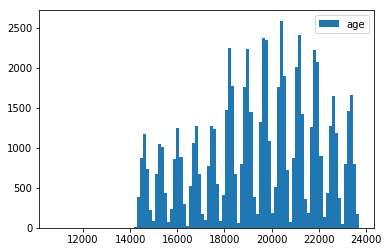

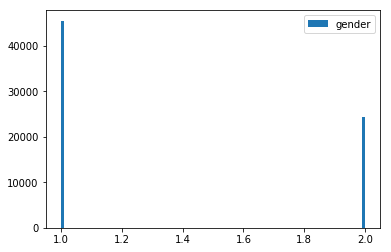

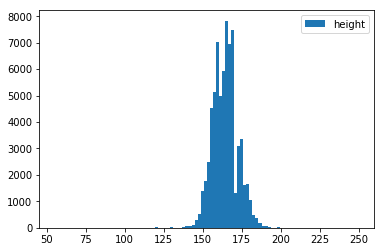

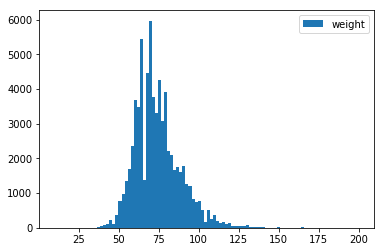

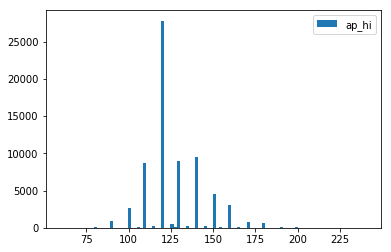

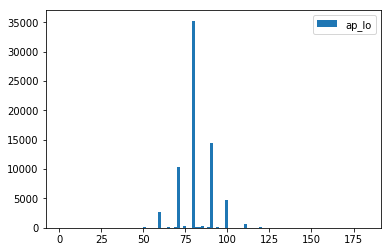

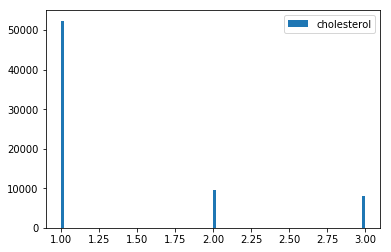

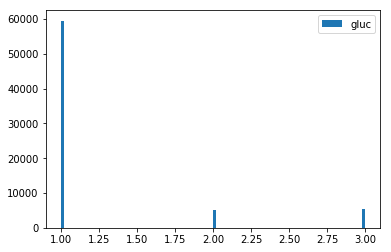

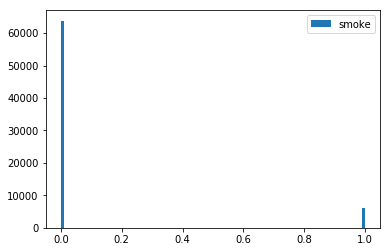

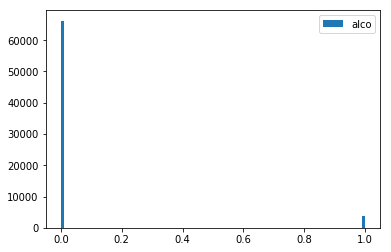

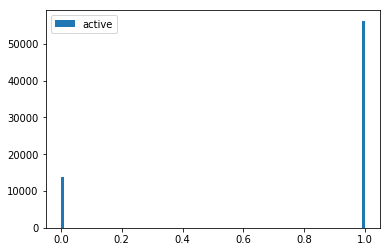

CPU times: user 8.32 s, sys: 5.78 s, total: 14.1 s
Wall time: 7.55 s


In [15]:
%%time
for col in train.columns:
    plt.hist(train[col] , bins=100)
    plt.legend([col])
    plt.show()

### Generate fich

In [16]:
%%time
def ad_hi_1(row):
    return 1.7*row['age']/365.25 + 83

def ad_lo_1(row):
    return 1.6*row['age']/365.25 + 42

def ad_hi_2(row):
    if row.gender == 2:
        return 109 + 0.5*row['age']/365.25 + 0.1*row['weight']
    return 102 + 0.7*row['age']/365.25 + 0.15*row['weight']

def ad_lo_2(row):
    if row.gender == 2:
        return 74 + 0.1*row['age']/365.25 + 0.15*row['weight']
    return 78 + 0.17*row['age']/365.25 + 0.1*row['weight']

def check_ap_hi(row):
    if row['ad_hi_2']  >= row['ap_hi']:
        return 1
    return 0

def check_ap_lo(row):
    if row['ad_lo_2'] <= row['ap_lo']:
        return 1
    return 0


train['ad_hi_1'] = train.apply(ad_hi_1, axis=1)
train['ad_lo_1'] = train.apply(ad_lo_1, axis=1)

train['ad_hi_2'] = train.apply(ad_hi_2, axis=1)
train['ad_lo_2'] = train.apply(ad_lo_2, axis=1)

train['check_ap_hi'] = train.apply(check_ap_hi, axis=1)
train['check_ap_lo'] = train.apply(check_ap_lo, axis=1)

train['diff_real'] = train['ap_hi'] - train['ap_lo']
train['diff_normal'] = train['ad_hi_2'] - train['ad_hi_2']

train['diff_real-diff_normal'] = train['diff_real'] - train['diff_normal']

test['ad_hi_1'] = test.apply(ad_hi_1, axis=1)
test['ad_lo_1'] = test.apply(ad_lo_1, axis=1)

test['ad_hi_2'] = test.apply(ad_hi_2, axis=1)
test['ad_lo_2'] = test.apply(ad_lo_2, axis=1)

test['check_ap_hi'] = test.apply(check_ap_hi, axis=1)
test['check_ap_lo'] = test.apply(check_ap_lo, axis=1)

test['diff_real'] = test['ap_hi'] - test['ap_lo']
test['diff_normal'] = test['ad_hi_2'] - test['ad_hi_2']

test['diff_real-diff_normal'] = test['diff_real'] - test['diff_normal']

CPU times: user 27.1 s, sys: 212 ms, total: 27.3 s
Wall time: 27.1 s


In [17]:
%%time
def check_weight_1(row):
    if row.gender == 2:
        return (row['height']*4/2.54 - 128)*0.453
    return (row['height']*3.5/2.54 - 108)*0.453

def check_weight_2(row):
    if row.gender == 2:
        return 48 + 2.7*(row['height']/2.54 - 60)
    return 45.5 +2.2 * (row['height']/2.54 - 60)

train['check_weight_1'] = train.apply(check_weight_1, axis = 1)
train['check_weight_2'] = train.apply(check_weight_2, axis = 1)
train['diff_real-normal_weight_1'] = train['weight'] - train['check_weight_1']
train['diff_real-normal_weight_2'] = train['weight'] - train['check_weight_2']
train['diff_normal_1-normal_2'] = train['check_weight_1'] - train['check_weight_2']

test['check_weight_1'] = test.apply(check_weight_1, axis = 1)
test['check_weight_2'] = test.apply(check_weight_2, axis = 1)
test['diff_real-normal_weight_1'] = test['weight'] - test['check_weight_1']
test['diff_real-normal_weight_2'] = test['weight'] - test['check_weight_2']
test['diff_normal_1-normal_2'] = test['check_weight_1'] - test['check_weight_2']

train['BMI'] = train['weight'] / (train['height']*train['height']/10000)
test['BMI'] = test['weight'] / (test['height']*test['height']/10000)

columns = train.columns

CPU times: user 8.78 s, sys: 56 ms, total: 8.84 s
Wall time: 8.81 s


In [19]:
%%time
def change(x , fich):
    le = LabelEncoder()
    le.fit(fich[[x]])
    fich['x_le'] = le.transform(fich[x])
    ohe = OneHotEncoder(sparse=False)
    new_ohe_features = ohe.fit_transform(fich.x_le.values.reshape(-1, 1))
    tmp = pd.DataFrame(new_ohe_features, columns=[x + str(i) for i in range(new_ohe_features.shape[1])] , index=fich.index)
    fich = pd.concat([fich, tmp], axis=1)
    fich.drop(['x_le'], axis=1 , inplace=True)
    return fich


def fich_bins(x , fich , bins):
    a = np.histogram(x[fich], bins=bins)
    for i in range(bins):
        def f(row):
            if i == 0:
                if row[fich] < a[0][i]:
                    return 1
            elif i == bins - 1:
                if row[fich] > a[0][i]:
                    return 1
            else:
                if a[0][i-1] < row[fich] < a[0][i+1]:
                    return 1
            return 0
        x[fich + str(i)] = x.apply(f , axis = 1)
    return x

pandas = pd.concat([train, test])
pandas.index = range(len(train) + len(test))

for fich in tqdm(columns):
    col = len(train.groupby(fich))
    if col < 10:
        pandas = change(fich , pandas)
#По гистограммам        
pandas = fich_bins(pandas , 'age' , 13)
pandas = fich_bins(pandas , 'ap_hi' , 10)
pandas = fich_bins(pandas , 'ap_lo' , 6)

train = pandas.loc[range(len(train))]
train.index = range(len(train))
test = pandas.loc[range(len(train) , len(train) + len(test))]
test.index = range(len(test))

100%|██████████| 26/26 [00:05<00:00,  5.11it/s]


CPU times: user 1min 32s, sys: 1.11 s, total: 1min 33s
Wall time: 1min 33s


In [21]:
%%time
def bmi_1(row):
    if (row['BMI'] <= 16):
        return 1
    return 0

def bmi_2(row):
    if (row['BMI'] <= 18.5 and row['BMI'] > 16):
        return 1
    return 0

def bmi_3(row):
    if (row['BMI'] <= 25 and row['BMI'] > 18.5):
        return 1
    return 0

def bmi_4(row):
    if (row['BMI'] <= 30 and row['BMI'] > 25):
        return 1
    return 0

def bmi_5(row):
    if (row['BMI'] <= 35 and row['BMI'] > 30):
        return 1
    return 0

def bmi_6(row):
    if (row['BMI'] <= 40 and row['BMI'] > 35):
        return 1
    return 0

def bmi_7(row):
    if (row['BMI'] > 40):
        return 1
    return 0

train['BMI_1'] = train.apply(bmi_1, axis=1)
train['BMI_2'] = train.apply(bmi_2, axis=1)
train['BMI_3'] = train.apply(bmi_3, axis=1)
train['BMI_4'] = train.apply(bmi_4, axis=1)
train['BMI_5'] = train.apply(bmi_5, axis=1)
train['BMI_6'] = train.apply(bmi_6, axis=1)
train['BMI_7'] = train.apply(bmi_7, axis=1)

test['BMI_1'] = test.apply(bmi_1, axis=1)
test['BMI_2'] = test.apply(bmi_2, axis=1)
test['BMI_3'] = test.apply(bmi_3, axis=1)
test['BMI_4'] = test.apply(bmi_4, axis=1)
test['BMI_5'] = test.apply(bmi_5, axis=1)
test['BMI_6'] = test.apply(bmi_6, axis=1)
test['BMI_7'] = test.apply(bmi_7, axis=1)

CPU times: user 21.2 s, sys: 456 ms, total: 21.6 s
Wall time: 21.5 s


In [22]:
%%time
train['risk'] = 1
train['risk_1'] = 1
train['risk_2'] = 1
train['risk_3'] = 1
test['risk'] = 1
test['risk_1'] = 1
test['risk_2'] = 1
test['risk_3'] = 1

def risk_1(row):
    if row.smoke == 1:
        row['risk_1'] = row['risk_1']*2.87
    if row.alco == 1:
        row['risk_1'] = row['risk_1']*2
    if row.active == 1:
        row['risk_1'] = row['risk_1']*0.86
    return row['risk_1']

def risk_2(row):
    if row.cholesterol == 2:
        row['risk_2'] = row['risk_2']*2
    if row.cholesterol == 3:
        row['risk_2'] = row['risk_2']*3.25
    if row.gluc == 1:
        row['risk_2'] = row['risk_2']*2.37
    return row['risk_2']

def risk_3(row):
    if row.check_ap_hi == 1:
        row['risk_3'] = row['risk_3']*1.91
    if row.BMI >= 30:
        row['risk_3'] = row['risk_3']*1.62
    return row['risk_3']

train['risk_1'] = train.apply(risk_1 , axis = 1)
train['risk_2'] = train.apply(risk_2 , axis = 1)
train['risk_3'] = train.apply(risk_3 , axis = 1)
train['risk'] = train['risk_1']*train['risk_2']*train['risk_3'] 

test['risk_1'] = test.apply(risk_1 , axis = 1)
test['risk_2'] = test.apply(risk_2 , axis = 1)
test['risk_3'] = test.apply(risk_3 , axis = 1)
test['risk'] = test['risk_1']*test['risk_2']*test['risk_3'] 

CPU times: user 30.7 s, sys: 292 ms, total: 31 s
Wall time: 30.8 s


In [23]:
%%time
train['second_risk_1'] = 1
train['second_risk_2'] = 1
train['second_risk_3'] = 1
train['second_risk'] = 1
test['second_risk_1'] = 1
test['second_risk_2'] = 1
test['second_risk_3'] = 1
test['second_risk'] = 1

def second_risk_1(row):
    if row.gender == 2:
        if row.smoke == 1:
            row['second_risk_1'] = row['second_risk_1']*1.38
    else:
        if row.smoke == 1:
            row['second_risk_1'] = row['second_risk_1']*1.08
    return row['second_risk_1']


def second_risk_2(row):
    if row.gender == 2:
        if row.cholesterol == 2:
            row['second_risk_2'] = row['second_risk_2']*1.18
        if row.cholesterol == 3:
            row['second_risk_2'] = row['second_risk_2']*1.37
        if row.gluc == 1:
            row['second_risk_2'] = row['second_risk_2']*1.1
    else:
        if row.cholesterol == 2:
            row['second_risk_2'] = row['second_risk_2']*1.2
        if row.cholesterol == 3:
            row['second_risk_2'] = row['second_risk_2']*1.4
    return row['second_risk_2']

def second_risk_3(row):
    if row.gender == 2:
        if row.check_ap_hi == 1:
            row['second_risk_3'] = row['second_risk_3']*1.29
        if row.BMI >= 30:
            row['second_risk_3'] = row['second_risk_3']*1.1
    else:
        if row.check_ap_hi == 1:
            row['second_risk_3'] = row['second_risk_3']*1.09
        if row.BMI >= 30:
            row['second_risk_3'] = row['second_risk_3']*1.14
    return row['second_risk_3']

train['second_risk_1'] = train.apply(second_risk_1 , axis = 1)
train['second_risk_2'] = train.apply(second_risk_2 , axis = 1)
train['second_risk_3'] = train.apply(second_risk_3 , axis = 1)
train['second_risk'] = train['second_risk_1']*train['second_risk_2']*train['second_risk_3'] 

test['second_risk_1'] = test.apply(second_risk_1 , axis = 1)
test['second_risk_2'] = test.apply(second_risk_2 , axis = 1)
test['second_risk_3'] = test.apply(second_risk_3 , axis = 1)
test['second_risk'] = test['second_risk_1']*test['second_risk_2']*test['second_risk_3'] 

CPU times: user 28.5 s, sys: 280 ms, total: 28.8 s
Wall time: 28.6 s


In [24]:
train['diff_risk'] = train['risk'] - train['second_risk']
test['diff_risk'] = test['risk'] - test['second_risk']

In [ ]:
%%time
for i in tqdm(range(len(columns))):
    for j in range(i + 1 , len(columns)):
        train[columns[i] + ' + ' + columns[j]] = train[columns[i]] + train[columns[j]]
        train[columns[i] + ' - ' + columns[j]] = train[columns[i]] - train[columns[j]]
        train[columns[i] + ' * ' + columns[j]] = train[columns[i]] * train[columns[j]]
        if (len(train[train[columns[j]] == 0]) == 0):
            train[columns[i] + ' / ' + columns[j]] = train[columns[i]] / train[columns[j]]    
            
        test[columns[i] + ' + ' + columns[j]] = test[columns[i]] + test[columns[j]]
        test[columns[i] + ' - ' + columns[j]] = test[columns[i]] - test[columns[j]]
        test[columns[i] + ' * ' + columns[j]] = test[columns[i]] * test[columns[j]]
        if (len(test[test[columns[j]] == 0]) == 0):
            test[columns[i] + ' / ' + columns[j]] = test[columns[i]] / test[columns[j]]
    if (train[columns[i]].min() > 0) and (test[columns[i]].min() > 0):
        def log(row):
            return math.log1p(row[columns[i]])
        train['log' + columns[i]] = train.apply(log, axis = 1)
        test['log' + columns[i]] = test.apply(log , axis = 1)

### Split data

In [25]:
x_train , x_valid , y_train , y_valid = train_test_split(train , res , test_size = valid_size ,random_state = random_state)
x_train.index = range(len(x_train))
y_train.index = range(len(y_train))
x_valid.index = range(len(x_valid))
y_valid.index = range(len(y_valid))

### Tune parametr

In [37]:
def fit(x_train , y_train , loss , best_param , param , model):
    scores = cross_val_score(model, x_train.values, y_train[1].values, cv=num_fold , scoring='neg_log_loss')
    result = -scores.mean()
    if(result < loss):
        loss = result
        best_param = param
    return loss , best_param

def tune_xgb(x_train , x_valid , y_train , y_valid , search = False):
    best_depth = 1
    best_col = 0.8
    best_child = 10
    n_estimators = 100
    learning_rate = 0.1
    loss = 1
    
    max_depth = range(1 , 10)
    for depth in tqdm(max_depth):
        model = xgb.XGBClassifier(max_depth = depth , learning_rate=learning_rate , min_child_weight=best_child , n_estimators=n_estimators , colsample_bytree=best_col)
        loss , best_depth = fit(x_train , y_train , loss , best_depth , depth , model)
    print 'loss = ', loss , 'best_depth = ' , best_depth
    
    one_of_fich = 1.0/train.shape[1]
    step = int(math.sqrt(train.shape[1]/2))
    if(step == 0):
        step = one_of_fich
        
    cols = np.arange(one_of_fich*step , 1 - one_of_fich*step  , one_of_fich*step)
    for col in tqdm(cols):
        model = xgb.XGBClassifier(max_depth = best_depth , colsample_bytree=col , min_child_weight=best_child , n_estimators=n_estimators , learning_rate=learning_rate)
        loss , best_col = fit(x_train , y_train , loss , best_col , col , model)
    print 'loss = ', loss , 'best_col = ' , best_col
    cols = np.arange(best_col - one_of_fich*step , best_col + one_of_fich*step , one_of_fich)
    for col in tqdm(cols):
        model = xgb.XGBClassifier(max_depth = best_depth , colsample_bytree=col , min_child_weight=best_child , n_estimators=n_estimators , learning_rate=learning_rate)
        loss , best_col = fit(x_train , y_train , loss , best_col , col, model)
    print 'loss = ', loss , 'best_col = ' , best_col
    
    min_child = range(5 , 20)
    for child in tqdm(min_child):
        model = xgb.XGBClassifier(max_depth = best_depth , colsample_bytree=best_col , min_child_weight=child , n_estimators=n_estimators , learning_rate=learning_rate)
        loss , best_child = fit(x_train , y_train , loss , best_child , child, model)
    print 'loss = ', loss , 'best_child = ' , best_child
    
    if(search):
        print 'Start GridSearchCV'
        tuned_parameters = [{'n_estimators': [100 , 500, 1000], 'learning_rate': np.arange(0.01 , 0.1 , 0.02)}]
        model = xgb.XGBClassifier(max_depth = best_depth, min_child_weight=child , colsample_bytree=best_col)
        clf = GridSearchCV(model, tuned_parameters, cv=5, scoring='neg_log_loss')
        clf.fit(x_train.values, y_train[1].values)
        best_params = clf.best_params_
        y_pred = clf.predict_proba(x_valid.values)
        
        print 'score = ' , log_loss(y_valid , y_pred) , 'best_params = ', best_params
        
        n_estimators = best_params['n_estimators']
        learning_rate = best_params['learning_rate']
    
    print 'best_depth = ' , best_depth , ', best_col = ', best_col , ' , best_child = ', best_child , ' , n_estimators = ' , n_estimators , ' , learning_rate = ' , learning_rate
    return model

In [38]:
%%time
model = tune_xgb(x_train , x_valid , y_train , y_valid)



  0%|          | 0/9 [00:00<?, ?it/s]


 11%|█         | 1/9 [00:13<01:47, 13.41s/it]

 22%|██▏       | 2/9 [00:32<01:46, 15.22s/it]

 33%|███▎      | 3/9 [00:59<01:52, 18.79s/it]

 44%|████▍     | 4/9 [01:51<02:23, 28.75s/it]

 56%|█████▌    | 5/9 [02:55<02:36, 39.05s/it]

 67%|██████▋   | 6/9 [03:46<02:08, 42.90s/it]

 78%|███████▊  | 7/9 [04:47<01:36, 48.11s/it]

 89%|████████▉ | 8/9 [05:56<00:54, 54.51s/it]

100%|██████████| 9/9 [07:13<00:00, 61.30s/it]

  0%|          | 0/13 [00:00<?, ?it/s]

loss =  0.540062648656 best_depth =  4


  0%|          | 0/12 [00:00<?, ?it/s]

loss =  0.54000536789 best_col =  0.466666666667


  0%|          | 0/15 [00:00<?, ?it/s]

loss =  0.539960678624 best_col =  0.477777777778


100%|██████████| 15/15 [07:17<00:00, 26.29s/it]

loss =  0.539513017422 best_child =  18
best_depth =  4 , best_col =  0.477777777778  , best_child =  18  , n_estimators =  100  , learning_rate =  0.1
CPU times: user 1h 31min 15s, sys: 25.7 s, total: 1h 31min 41s
Wall time: 25min 9s


In [40]:
best_depth = model.get_params()['max_depth']
best_col = model.get_params()['colsample_bytree']
best_child = model.get_params()['min_child_weight']
n_estimators = model.get_params()['n_estimators']
learning_rate = model.get_params()['learning_rate']

### Stack xgboost with different seed

In [41]:
def diff_seed(x_train, y_train , x_valid , y_valid  , num_seed , max_depth = best_depth, min_child_weight=best_child , colsample_bytree=best_col, n_estimators = n_estimators , learning_rate=learning_rate):
    assert(num_seed > 0)
    model_seed = range(num_seed)
    pred_seed = range(num_seed)
    for i in tqdm(range(num_seed)):
        seed = i
        model_seed[i] = xgb.XGBClassifier(max_depth = best_depth, min_child_weight=best_child , colsample_bytree=best_col, n_estimators = n_estimators , learning_rate=learning_rate, seed = seed)
        model_seed[i].fit(x_train , y_train)
        pred_seed[i] = model_seed[i].predict_proba(x_valid)
    itog_pred = sum(pred_seed)/num_seed
    if (y_valid):
        print log_loss(y_valid , itog_pred)
    return itog_pred

In [42]:
pred = diff_seed(train, res , test , None , num_seed)

  0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
100%|██████████| 20/20 [03:00<00:00,  8.69s/it]


In [43]:
answ = pd.DataFrame(pred)[1]
answ.to_csv('simple_xgb.csv',index=None , header=None)

In [ ]:
from mlxtend.classifier import StackingCVClassifier , StackingClassifier
%%time
model_seed = range(num_seed + 1)
label = range(num_seed + 1)
for i in range(num_seed):
    model_seed[i] = xgb.XGBClassifier(max_depth = best_depth, min_child_weight=best_child , colsample_bytree=best_col, n_estimators=n_estimators , learning_rate=learning_rate , seed = i)

x_g_b = xgb.XGBClassifier(max_depth=4 , min_child_weight=10 , n_estimators=n_estimators , learning_rate=learning_rate , colsample_bytree=0.8)
sclf = StackingCVClassifier(classifiers=model_seed[:-1], use_probas=True, meta_classifier=x_g_b)
model_seed[num_seed] = sclf
label[num_seed] = 'Stack'

for clf, label in zip(model_seed, label):
    scores = model_selection.cross_val_score(clf, x_train.values ,y_train[1].values, scoring='neg_log_loss')
     print("log_loss: %0.5f (+/- %0.5f) [%s]"  % (-scores.mean(), scores.std(), label))
     
     
sclf.fit(x_train.values, y_train[1].values)
pred = sclf.predict_proba(x_valid.values)
result = log_loss(y_valid , pred)
print result